# CODE TO BUILD HIERARCHICAL MODEL:

## Data Loading:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [3]:
path = r'GT_IPI.parquet'
df = pd.read_parquet(path,engine = 'auto')

In [4]:
len(df.columns)

87

In [5]:
indices_df = pd.read_csv('unique_indexes.csv')
indices = indices_df['unique_index'].tolist()

In [6]:
filtered_df = df[df.index.isin(indices)]

# If you want to reset the index after filtering (optional)
filtered_df.reset_index(drop=True, inplace=True)

In [7]:
df = filtered_df

In [8]:
df.head()

,begins_with,css_pk,customer_pk,is_italic,is_bold,html_pk,id,is_underline,target,form_rel_depth,...,lang_pct_verb_gerund_present_participle,lang_pct_verb_past_participle,lang_pct_verb_sing_present_non_third_person,lang_pct_verb_3rd_person_sing_present,lang_pct_wh_determiner,lang_pct_wh_pronoun,lang_pct_possessive_wh_pronoun,lang_pct_wh_abverb,lang_pct_punct,lang_pct_sym
0,text,5625805,1855,0,0,5625806,423509|5625806|3941A609,0,question,82,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.176471,0.0
1,text,5625805,1855,0,0,5625806,423509|5625806|268B6CF4,0,question,84,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.200000,0.0
2,text,5625805,1855,0,0,5625806,423509|5625806|4DDFA3A2,0,question,86,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0
3,text,5625805,1855,0,0,5625806,423509|5625806|17955346,0,question,88,...,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.000000,0.0
4,text,5625805,1855,0,0,5625806,423509|5625806|48E6BE18,0,question,84,...,1.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0


In [9]:
# convert column with only 0 and 1 into boolean:
bool_column = df.apply({0,1}.issuperset)


In [10]:
bool_column_list = bool_column[bool_column == True].index.to_list()

In [11]:
print(bool_column_list)

['is_italic', 'is_bold', 'is_underline', 'form_font_family_mode_ind', 'form_font_colour_mode_ind', 'lang_ls_alnum', 'lang_ls_qm', 'lang_ls_fs', 'lang_ls_clscl', 'lang_ls_brkt', 'para_prec_bold_ind', 'para_foll_bold_ind', 'para_prec_italic_ind', 'para_foll_italic_ind', 'para_prec_underline_ind', 'para_foll_underline_ind', 'para_prec_font_ind', 'para_foll_font_ind', 'para_prec_colour_ind', 'para_foll_colour_ind', 'is_upper', 'is_title', 'style_bullet', 'style_table', 'style_list_num', 'style_heading', 'style_box', 'style_toc', 'style_q', 'style_ans', 'style_title', 'style_indent', 'style_cover_nm_add', 'style_head_foot']


In [12]:
style_counts_by_target = df.groupby('target')['style'].value_counts()

In [13]:
style_counts_by_target

target      style              
discarded   default                742189
            listparagraph          245797
            bodytext                99203
            tableparagraph          58103
            normal                  42611
                                    ...  
subsection  wfisubhead1                 1
            xxxmsolistparagraph         1
            xxxmsonormal                1
            xxxparagraphnormal          1
            ydlheader2                  1
Name: count, Length: 9974, dtype: int64

In [14]:
# too many style value in the column style
style_counts_by_target = df.groupby('target')['style'].value_counts()

# Convert the result to a DataFrame
style_counts_by_target_df = style_counts_by_target.to_frame(name='Count').reset_index()

# Initialize an empty list to hold the top 10 terms for each target
top_15_per_target = []

# Calculate the percentage representation and get the top 15 terms for each 'target'
for target in style_counts_by_target_df['target'].unique():
    # Filter the DataFrame for the current target
    target_df = style_counts_by_target_df[style_counts_by_target_df['target'] == target]
    
    # Calculate the total number of terms for the current target
    total_terms = target_df['Count'].sum()
    
    # Calculate the percentage representation of each term
    target_df['Percentage'] = (target_df['Count'] / total_terms) * 100
    
    # Get the top 15 terms
    top_15 = target_df.head(15)
    
    # Append the result to the list
    top_15_per_target.append(top_15)

# Concatenate all top 10 DataFrames into a single DataFrame
combined_top_15 = pd.concat(top_15_per_target)

# Display the unique 'style' values in the combined DataFrame
unique_styles = combined_top_15['style'].unique()
## manually remove title from the list as it is duplicated
#unique_styles = np.delete(unique_styles, np.where(unique_styles == 'title'))
print("Unique 'style' values in the top 15 per target:")
print(unique_styles)
# Transform the 'style' column to 'None' if the current value isn't found in unique_styles
df['style'] = df['style'].apply(lambda x: x if x in unique_styles else 'None')

C:\Users\shawn\AppData\Local\Temp\ipykernel_1820\3842439404.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Percentage'] = (target_df['Count'] / total_terms) * 100
C:\Users\shawn\AppData\Local\Temp\ipykernel_1820\3842439404.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Percentage'] = (target_df['Count'] / total_terms) * 100
C:\Users\shawn\AppData\Local\Temp\ipykernel_1820\3842439404.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Unique 'style' values in the top 15 per target:
['default' 'listparagraph' 'bodytext' 'tableparagraph' 'normal' 'heading2'
 'toc2' 'toc1' 'heading1' 'nospacing' 'heading3' 'normalweb' 'tabletext'
 'toc3' 'listnumber' 'question' 'dvquestion' 'paragraphedeliste'
 'esisquestion' 'title' 'heading4' 'heading10' 'paragraph' 'titre1'
 'dvsubcategory' 'rfpheading3' 'himheading4bodybold' 'heading20']


In [15]:
df['target'].unique()

array(['question', 'discarded', 'section', 'subsection'], dtype=object)

In [16]:
# Keep a copy of the original 'target' column
original_target = df['target'].copy()

# Apply one-hot encoding to the specified columns
#df_encoded = pd.get_dummies(df, columns=['target', 'begins_with', 'style'], prefix=['target', 'begins_with', 'style'])
df_encoded = pd.get_dummies(df,drop_first = True
                            , columns=['begins_with','para_foll_depth_ind','para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind', 'style'] + bool_column_list\
                            , prefix=['begins_with','para_foll_depth_ind','para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind', 'style'] + bool_column_list)
df_encoded = pd.get_dummies(df_encoded
                            , columns=['target']\
                            , prefix=['target'] )

# Add the original 'target' column back to the encoded DataFrame
df_encoded['target'] = original_target

In [17]:
customers_with_less_than2_csspk = [
    x for x in df_encoded['customer_pk'].unique() 
    if len(df_encoded[df_encoded['customer_pk'] == x]['css_pk'].unique()) < 2
]

filtered_df = df_encoded[~df_encoded['customer_pk'].isin(customers_with_less_than2_csspk)]

In [18]:
#array(['question', 'discarded', 'subsection', 'section'],
exclude = ['lang_num_sents','css_pk','customer_pk','html_pk','id']
#top_15_columns
top_15_columns = []
columns_to_exclude = exclude + top_15_columns

In [19]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)

train_list = []
test_list = []

for i in filtered_df['customer_pk'].unique():
    X = filtered_df.loc[filtered_df['customer_pk'] == i]
    train_index, test_index = next(gss.split(X, groups=X['css_pk']))
    
    train_list.append(X.iloc[train_index])
    test_list.append(X.iloc[test_index])

train_df = pd.concat(train_list, ignore_index=False)
test_df = pd.concat(test_list, ignore_index=False)

In [21]:
# save npy to folder
np.save('train_split_index_remove_duplicate.npy',np.array(train_df.index))
np.save('test_split_index_remove_duplicate.npy',np.array(test_df.index))

In [22]:
print(test_df.shape[0]/filtered_df.shape[0])
print(train_df.shape[0]/filtered_df.shape[0])

0.21674494503415928
0.7832550549658407


In [23]:
# load the npy back
c = np.load('test_split_index_remove_duplicate.npy')
c

array([ 140809,  140810,  140811, ..., 2974080, 2974081, 2974082],
      dtype=int64)

## Model Building:

### Sub model 1

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
# display confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from tune_sklearn import TuneSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

In [25]:
##FOR DISCARDED
#'target_question',target_discarded','target_subsection','target_section'
X_train = train_df.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_train = train_df['target_discarded']
X_test = test_df.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_test = test_df['target_discarded']

c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [15:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [15:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\shawn\AppData\Local\Programs\Python\Python39\li

Accuracy: 0.81
Classification report:
              precision    recall  f1-score   support

       False       0.82      0.79      0.80    339874
        True       0.79      0.82      0.81    336199

    accuracy                           0.81    676073
   macro avg       0.81      0.81      0.81    676073
weighted avg       0.81      0.81      0.81    676073



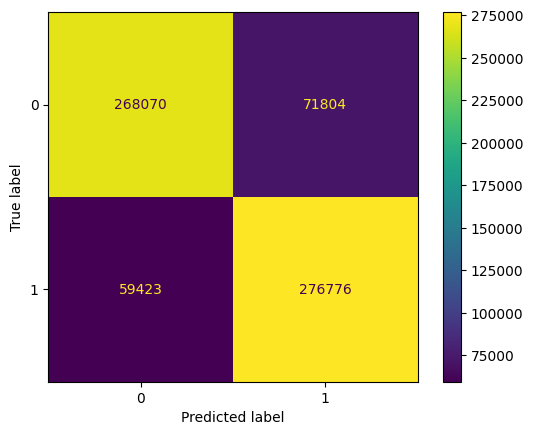

auc score: 0.88


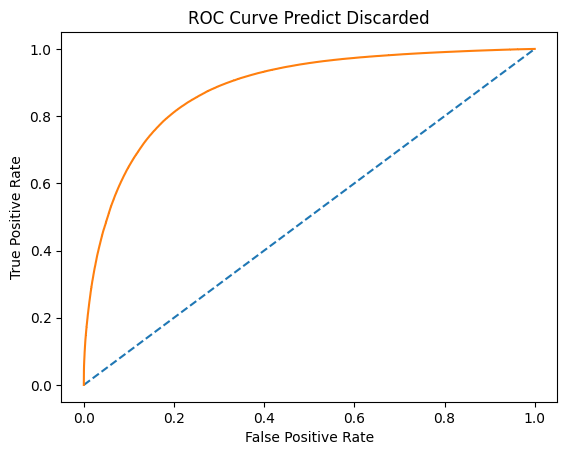

In [25]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  n_jobs=-1, device = 'cuda')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

In [26]:
def Grid_and_eval(classifier,params,X_train,y_train,X_test,y_test,cv=10 ):
    parameters = params
    model_cv = GridSearchCV(classifier,parameters,cv=cv,scoring='f1',verbose=0)
    model_cv.fit(X_train,y_train) 
    print("Tuned hyperparameters: ",model_cv.best_params_)
    print("Mean CV f1_score of best_estimator, on Training:",model_cv.best_score_)
    best_model = model_cv.best_estimator_
    print("Best estimator:",best_model)
    print("f1 on Test data (Positive case only):",model_cv.score(X_test,y_test))
    print("f1 on Train data:",model_cv.score(X_train,y_train))

    y_pred=model_cv.predict(X_test)   #Using the best found params 
    y_pred_prob = model_cv.predict_proba(X_test)
    print("Classification report:") 
    print(classification_report(y_test,y_pred))#,output_dict=True)) 
    cm = confusion_matrix(y_test, y_pred, labels=model_cv.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_cv.classes_)
    disp.plot()
    plt.show()
    
    precision, recall, f1_res, _ = precision_recall_fscore_support(y_test,y_pred,average='weighted')
    
    ######## ROC curve ############
    auc = roc_auc_score(y_test, y_pred_prob[:,1])
    fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])

    plt.plot([0,1],[0,1],'--')
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Predict Discarded')
    plt.show()
    return [f1_res,auc,precision,recall]

In [27]:
X_train.shape

(2443137, 112)

In [28]:
## trim the data to tune: data file is too big:
##FOR DISCARDED
#'target_question',target_discarded','target_subsection','target_section'

X_train = train_df.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_train = train_df['target_discarded']
X_test = test_df.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_test = test_df['target_discarded']

In [29]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.75, random_state= 66)
for kept_index,truncate_index in sss.split(X=X_train,y=y_train):
    train_kept_index = kept_index
    train_truncate_index = truncate_index
    kept_X, kept_y = X_train[X_train.index.isin(kept_index)], y_train[y_train.index.isin(kept_index)]
    truncate_X, truncate_y = X_train[X_train.index.isin(truncate_index)], y_train[y_train.index.isin(truncate_index)]


In [30]:
# save npy to folder
np.save('train_kept_split_index_remove_duplicate.npy',train_kept_index)
np.save('train_truncated_split_index_remove_duplicate.npy',train_truncate_index)

In [20]:
from tune_sklearn import TuneSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score,roc_auc_score

In [31]:
kept_X.shape

(479334, 112)

In [32]:
xgb1 = xgb.XGBClassifier(objective= "binary:logistic",nthread = -1, device = 'cuda',eval_metric='auc')
param1 = {'max_depth': [9,18,27],
              'learning_rate': [0.05, 0.15, 0.3,0.025],
              'subsample': np.arange(0.5, 1.0, 0.1).tolist(),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1).tolist(),
              'n_estimators': [100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=xgb1, 
                           param_distributions=param1, 
                           n_iter=20,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(kept_X, kept_y)
#print(random_search.best_params_)
#print(random_search.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           n_estimators=None, n_jobs=None,
                                           nthread=-1, num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999],
                                        'learning_rate': [0.05, 0.15, 0.3,
                                                          0.025],
                                        'max_depth': [9, 18, 27],
                                        'n_estimators': [100, 150, 300],
                                        'subsample': [0.5, 0.6, 0.7,
                                                      0.7999999999999999,
                                                      0.8999999999999999]},
                   refit='f1', scoring='f1', verbose=1)

In [34]:
print(random_search.best_params_)
print(random_search.cv_results_)
print(random_search.best_score_)

{'subsample': 0.8999999999999999, 'n_estimators': 300, 'max_depth': 27, 'learning_rate': 0.025, 'colsample_bytree': 0.5}
{'mean_fit_time': array([ 246.30647602,  237.84060774,   89.14919763,   26.78499918,
       1108.4447721 , 1264.11554923, 2659.64031572,  116.03900523,
        437.27960072, 4228.31325116, 1274.76269131,   56.20640092,
       1384.02338157, 5744.49726896,  493.92087212,  220.26437473,
         25.58399997,   11.47339573,   14.00720034,   21.31139531]), 'std_fit_time': array([7.15163910e+01, 1.17138652e+02, 1.82250758e+01, 1.25833240e+00,
       3.56971992e+02, 1.36220962e+02, 5.27725154e+02, 2.00406039e+01,
       1.35645495e+02, 7.24492732e+02, 3.11311327e+02, 4.67311628e+00,
       3.70035204e+02, 1.81536876e+03, 1.27725474e+02, 6.13541111e+01,
       2.73356427e+00, 1.19002611e+00, 6.44349059e-01, 3.27574420e+00]), 'mean_score_time': array([1.63399997, 1.54340129, 1.49660058, 2.51541014, 3.30836158,
       1.96479926, 3.47879944, 1.79839325, 2.70539994, 3.50800056

c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [08:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_job" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [08:59:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warni

Accuracy: 0.83
Classification report:
              precision    recall  f1-score   support

       False       0.84      0.81      0.83    339874
        True       0.81      0.85      0.83    336199

    accuracy                           0.83    676073
   macro avg       0.83      0.83      0.83    676073
weighted avg       0.83      0.83      0.83    676073



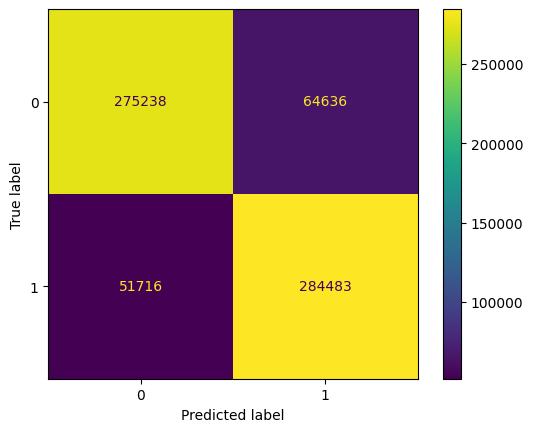

auc score: 0.91


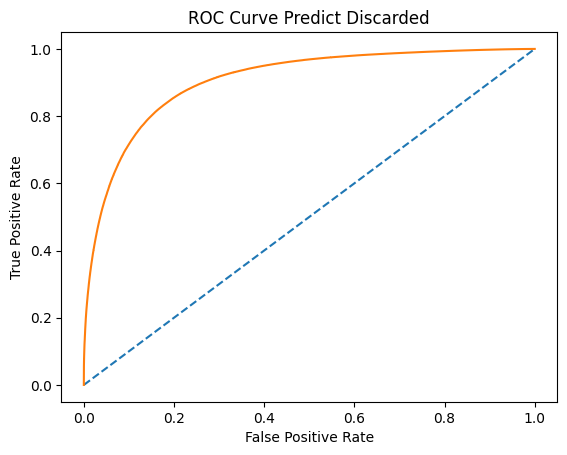

In [35]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model1_tuned = xgb.XGBClassifier(objective= "binary:logistic",n_job = -1,  tree_method='hist',eval_metric='auc',device='cuda'
                          ,max_depth=27,
              learning_rate=0.025,#0.15
              subsample=0.9,
              colsample_bytree=0.5,#0.6
              n_estimators=300)

# Train the model
model1_tuned.fit(X_train, y_train)

# Make predictions
y_pred = model1_tuned.predict(X_test)
y_pred_prob = model1_tuned.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test, y_pred, labels=model1_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model1_tuned.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

#### Random Forest:

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
clf1 = RandomForestClassifier(n_jobs = -1,oob_score = f1_score)
clf1.fit(kept_X, kept_y)

RandomForestClassifier(n_jobs=-1,
                       oob_score=<function f1_score at 0x0000018381B32DC0>)

In [50]:
clf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Accuracy: 0.81
Classification report:
              precision    recall  f1-score   support

       False       0.82      0.79      0.80    339874
        True       0.79      0.82      0.81    336199

    accuracy                           0.81    676073
   macro avg       0.81      0.81      0.81    676073
weighted avg       0.81      0.81      0.81    676073



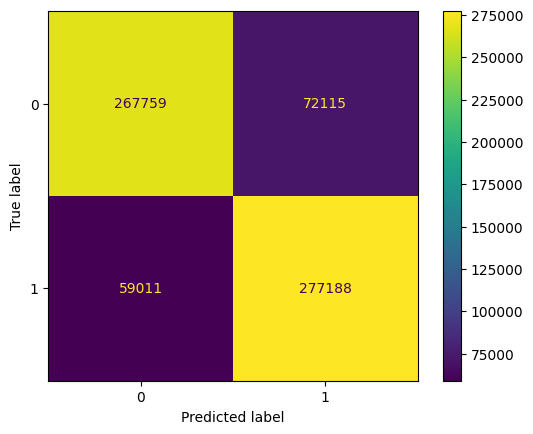

auc score: 0.88


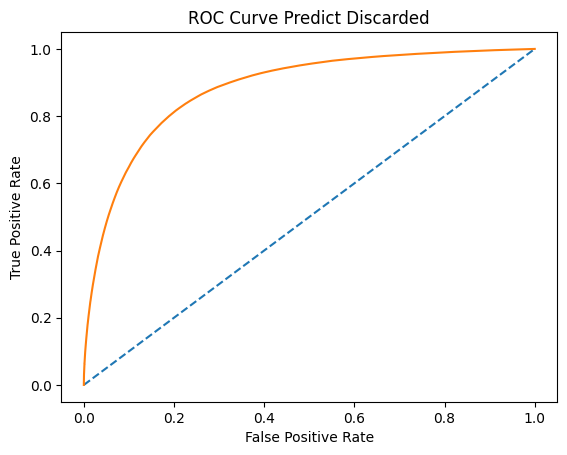

In [41]:

# Make predictions
y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test, y_pred, labels=model1_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model1_tuned.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

In [51]:
clf1_tune = RandomForestClassifier(n_jobs = -1,oob_score = f1_score, bootstrap = True)
param1 = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(20, 110, 20).tolist(),
              'min_samples_split':[2,10,30],
              'min_samples_leaf':[2,5,10],
              'n_estimators': [100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=clf1_tune, 
                           param_distributions=param1, 
                           n_iter=10,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(kept_X, kept_y)
#print(random_search.best_params_)
#print(random_search.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    oob_score=<function f1_score at 0x0000018381B32DC0>),
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [20, 40, 60, 80, 100],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 10, 30],
                                        'n_estimators': [100, 150, 300]},
                   refit='f1', scoring='f1', verbose=1)

In [52]:
print(random_search.best_params_)
print(random_search.cv_results_)
print(random_search.best_score_)

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 40, 'criterion': 'log_loss'}
{'mean_fit_time': array([100.16003046,  97.0859992 ,  91.69920578,  91.39839907,
        87.4457149 , 100.03680425, 287.53279238,  87.45619874,
       129.15279355, 100.19219313]), 'std_fit_time': array([ 0.82927038,  4.56407093,  4.92749918,  3.40459859,  5.88777943,
        3.22515356, 12.85503855, 14.72494471,  4.77211124, 24.04572791]), 'mean_score_time': array([1.39520655, 1.92700362, 1.83299518, 3.06179934, 3.22099562,
       4.02840114, 5.95000987, 2.74640346, 2.82200737, 1.36460657]), 'std_score_time': array([0.39101732, 0.94052358, 0.52899081, 1.22740236, 0.95896747,
       1.47754472, 2.03258224, 0.92147125, 1.10253713, 0.78342844]), 'param_n_estimators': masked_array(data=[100, 100, 100, 100, 100, 100, 300, 100, 150, 150],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=999999), 'param_mi

### Sub model 2.1 - question from others

In [36]:
##FOR question
#'target_question',target_discarded','target_subsection','target_section'
train_df_2 = train_df.loc[train_df['target_discarded'] != 1]
test_df_2 = test_df.loc[test_df['target_discarded'] != 1]
X_train_2 = train_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_train_2 = train_df_2['target_question']
X_test_2 = test_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_test_2 = test_df_2['target_question']


In [21]:
import imblearn

In [38]:
train_df_2.groupby('target_question').count()

,css_pk,customer_pk,html_pk,id,form_rel_depth,form_rel_font_size,lang_num_sents,lang_num_words,lang_mean_words_per_sent,lang_pct_coordinating_conjunction,...,style_q_1,style_ans_1,style_title_1,style_indent_1,style_cover_nm_add_1,style_head_foot_1,target_discarded,target_section,target_subsection,target
target_question,,,,,,,,,,,,,,,,,,,,,
False,82188,82188,82188,82188,82188,82188,82188,82188,82188,82188,...,82188,82188,82188,82188,82188,82188,82188,82188,82188,82188
True,1131836,1131836,1131836,1131836,1131836,1131836,1131836,1131836,1131836,1131836,...,1131836,1131836,1131836,1131836,1131836,1131836,1131836,1131836,1131836,1131836


In [37]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

Accuracy: 0.94
Classification report:
              precision    recall  f1-score   support

       False       0.51      0.89      0.65     22822
        True       0.99      0.94      0.96    317052

    accuracy                           0.94    339874
   macro avg       0.75      0.92      0.81    339874
weighted avg       0.96      0.94      0.94    339874



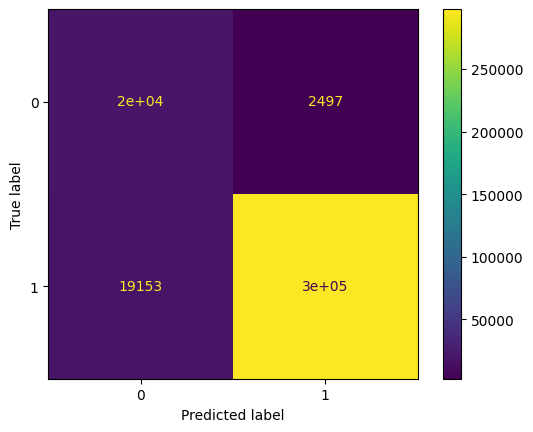

auc score: 0.97


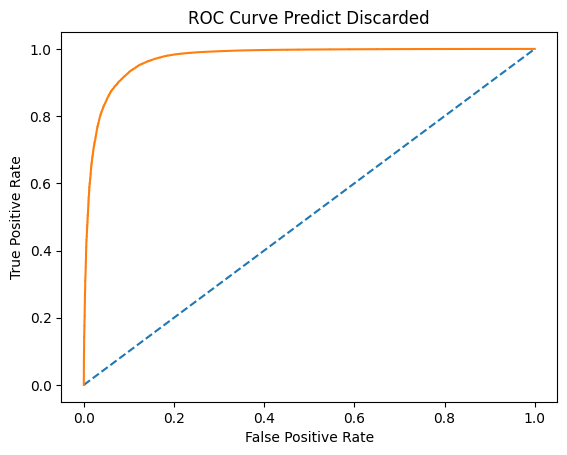

In [42]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model2 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  n_jobs=-1)

# Train the model
model2.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model2.predict(X_test_2)
y_pred_prob = model2.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model2.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

#### Tune model

In [26]:
from tune_sklearn import TuneSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score,roc_auc_score

In [27]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.75, random_state= 66)
for kept_index,truncate_index in sss.split(X=X_train_over,y=y_train_over):
    train_kept_index = kept_index
    train_truncate_index = truncate_index
    kept_X, kept_y = X_train_over[X_train_over.index.isin(kept_index)], y_train_over[y_train_over.index.isin(kept_index)]
    truncate_X, truncate_y = X_train_over[X_train_over.index.isin(truncate_index)], y_train_over[y_train_over.index.isin(truncate_index)]

In [32]:
xgb2_tune = xgb.XGBClassifier(objective= "binary:logistic",nthread = -1, device = 'cuda',eval_metric='auc')
param1 = {'max_depth': [6,9,18],
              'learning_rate': [0.05, 0.15, 0.3],
              'subsample': np.arange(0.5, 1.0, 0.1).tolist(),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1).tolist(),
              'n_estimators': [50,100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=xgb2_tune, 
                           param_distributions=param1, 
                           n_iter=30,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(kept_X, kept_y)
#print(random_search.best_params_)
#print(random_search.cv_results_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           n_estimators=None, n_jobs=None,
                                           nthread=-1, num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999],
                                        'learning_rate': [0.05, 0.15, 0.3],
                                        'max_depth': [6, 9, 18],
                                        'n_estimators': [50, 100, 150, 300],
                                        'subsample': [0.5, 0.6, 0.7,
                                                      0.7999999999999999,
                                                      0.8999999999999999]},
                   refit='f1', scoring='f1', verbose=1)

In [33]:
print(random_search.best_params_)
print(random_search.cv_results_)
print(random_search.best_score_)

{'subsample': 0.8999999999999999, 'n_estimators': 300, 'max_depth': 18, 'learning_rate': 0.15, 'colsample_bytree': 0.6}
{'mean_fit_time': array([ 27.87979994,  38.54279504,  43.74719939,  91.37999916,
         7.97060127,  68.08940015,  13.61720023,   7.34680252,
       111.34839931,  11.95919847,  56.04063315,  17.71119828,
        16.49939847,  30.92699938, 188.47339954,  26.04119658,
        14.57039618,  71.30379796,  13.6501976 ,  15.19640245,
        11.54279914,  92.10597739,  16.78040009,  13.05720086,
        18.71259861,  11.00520077,   7.74740191,   8.12579975,
        69.55540171,  11.61020007]), 'std_fit_time': array([ 1.24486774,  5.15997068,  1.78770491,  4.51520107,  0.42014898,
       11.64468577,  1.08108302,  0.23541594, 37.13813632,  1.89821104,
        6.14810607,  0.94884527,  2.68120115,  4.06344053, 52.01817289,
        0.86786365,  1.67387365,  9.84626566,  1.49067821,  2.20926046,
        1.16249593, 16.94768805,  0.57985553,  1.16020887,  1.21853505,
        

c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [19:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.97
Classification report:
              precision    recall  f1-score   support

       False       0.79      0.80      0.80     22822
        True       0.99      0.98      0.99    317052

    accuracy                           0.97    339874
   macro avg       0.89      0.89      0.89    339874
weighted avg       0.97      0.97      0.97    339874



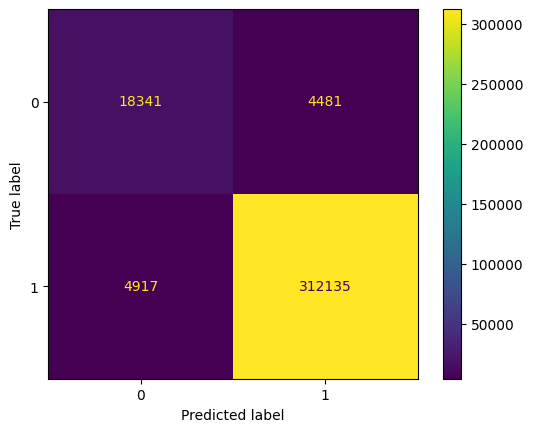

auc score: 0.97


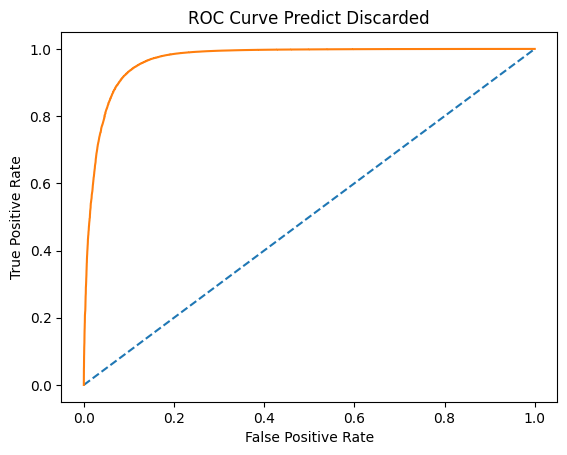

In [41]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model2 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  nthread = -1, device = 'cuda', 
                           subsample=0.9, n_estimators= 300, max_depth= 18, 
                           learning_rate= 0.15, colsample_bytree= 0.6)

# Train the model
model2.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model2.predict(X_test_2)
y_pred_prob = model2.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model2.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

<Axes: >

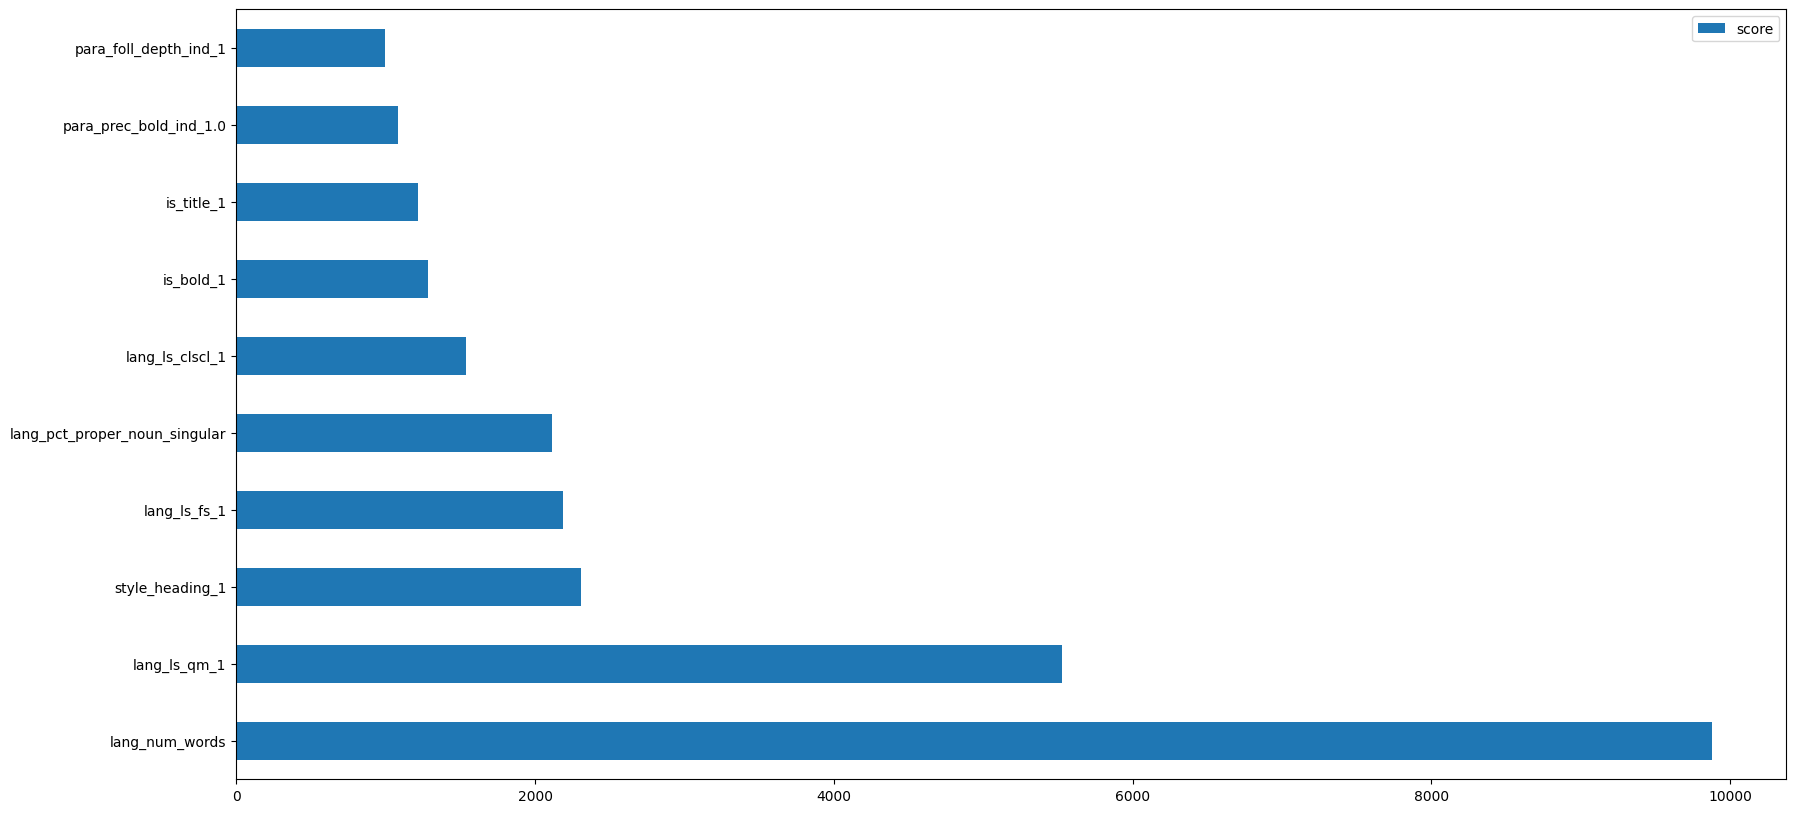

In [44]:
## Important features
feature_important = model2.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

#### Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf2 = RandomForestClassifier(njob = -1,oob_score = 'auc')
param1 = {'criterion': ['gini', 'entropy', 'log_loss'],
              'bootstrap': [True, False],
              'max_depth': np.arange(20, 110, 20).tolist().append(None),
              'min_samples_split':[1,2,4],
              'min_samples_leaf':[2,5,10],
              'n_estimators': [100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=clf2, 
                           param_distributions=param1, 
                           n_iter=20,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(kept_X, kept_y)
#print(random_search.best_params_)
#print(random_search.cv_results_)

### Sub model 2.2 - section from others

In [56]:
##FOR section
#'target_question',target_discarded','target_subsection','target_section'
train_df_2 = train_df.loc[train_df['target_discarded'] != 1]
test_df_2 = test_df.loc[test_df['target_discarded'] != 1]
X_train_2 = train_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_train_2 = train_df_2['target_section']
X_test_2 = test_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_test_2 = test_df_2['target_section']


In [57]:
train_df_2.groupby('target_section').count()

,css_pk,customer_pk,html_pk,id,form_rel_depth,form_rel_font_size,lang_num_sents,lang_num_words,lang_mean_words_per_sent,lang_pct_coordinating_conjunction,...,style_q_1,style_ans_1,style_title_1,style_indent_1,style_cover_nm_add_1,style_head_foot_1,target_discarded,target_question,target_subsection,target
target_section,,,,,,,,,,,,,,,,,,,,,
False,1167460,1167460,1167460,1167460,1167460,1167460,1167460,1167460,1167460,1167460,...,1167460,1167460,1167460,1167460,1167460,1167460,1167460,1167460,1167460,1167460
True,46564,46564,46564,46564,46564,46564,46564,46564,46564,46564,...,46564,46564,46564,46564,46564,46564,46564,46564,46564,46564


In [58]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

Accuracy: 0.94
Classification report:
              precision    recall  f1-score   support

       False       1.00      0.94      0.97    326804
        True       0.39      0.92      0.55     13070

    accuracy                           0.94    339874
   macro avg       0.69      0.93      0.76    339874
weighted avg       0.97      0.94      0.95    339874



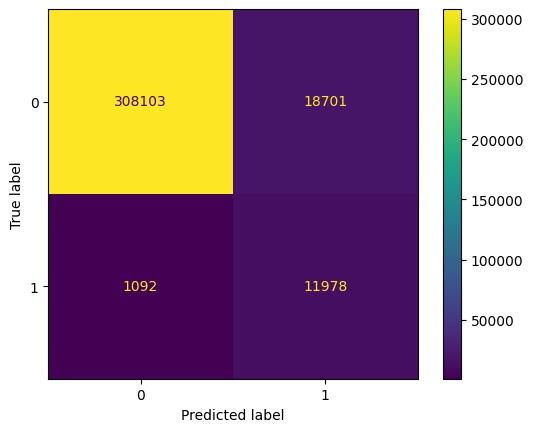

auc score: 0.98


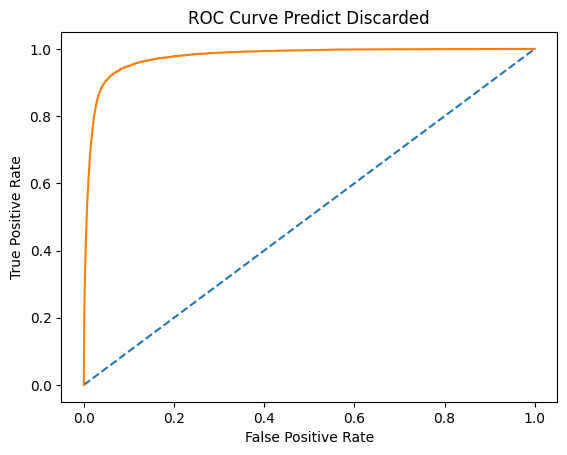

In [59]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model3 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  n_jobs=-1)

# Train the model
model3.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model3.predict(X_test_2)
y_pred_prob = model3.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model3.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

### Submodel 2.3 - subsection from others

In [44]:
##FOR section
#'target_question',target_discarded','target_subsection','target_section'
train_df_2 = train_df.loc[train_df['target_discarded'] != 1]
test_df_2 = test_df.loc[test_df['target_discarded'] != 1]
X_train_2 = train_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_train_2 = train_df_2['target_subsection']
X_test_2 = test_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_test_2 = test_df_2['target_subsection']


In [45]:
train_df_2.groupby('target_subsection').count()

,css_pk,customer_pk,html_pk,id,form_rel_depth,form_rel_font_size,lang_num_sents,lang_num_words,lang_mean_words_per_sent,lang_pct_coordinating_conjunction,...,style_q_1,style_ans_1,style_title_1,style_indent_1,style_cover_nm_add_1,style_head_foot_1,target_discarded,target_question,target_section,target
target_subsection,,,,,,,,,,,,,,,,,,,,,
False,1178400,1178400,1178400,1178400,1178400,1178400,1178400,1178400,1178400,1178400,...,1178400,1178400,1178400,1178400,1178400,1178400,1178400,1178400,1178400,1178400
True,35624,35624,35624,35624,35624,35624,35624,35624,35624,35624,...,35624,35624,35624,35624,35624,35624,35624,35624,35624,35624


In [46]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

Accuracy: 0.88
Classification report:
              precision    recall  f1-score   support

       False       1.00      0.88      0.94    330122
        True       0.18      0.86      0.29      9752

    accuracy                           0.88    339874
   macro avg       0.59      0.87      0.61    339874
weighted avg       0.97      0.88      0.92    339874



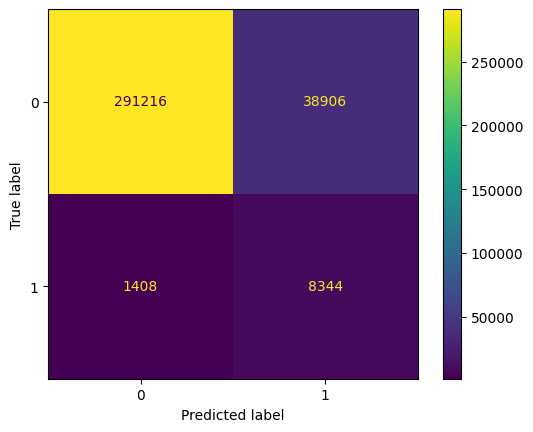

auc score: 0.94


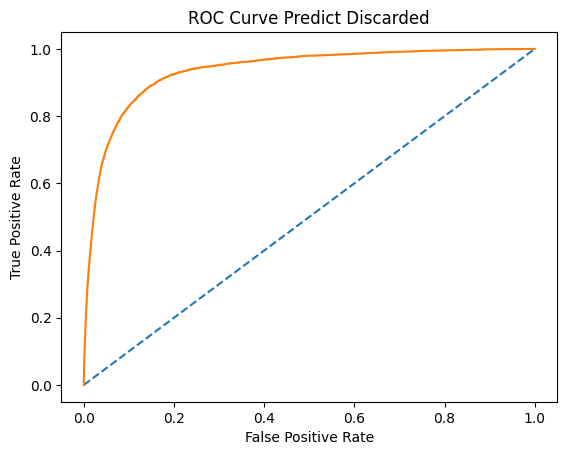

In [47]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  n_jobs=-1)

# Train the model
model.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model.predict(X_test_2)
y_pred_prob = model.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

#### With all 3 sub models created, it is cleared that using question as the second target yield the best second model

### sub model 3.1 section from others

In [45]:
##FOR section
#'target_question',target_discarded','target_subsection','target_section'
train_df_2 = train_df.loc[(train_df['target_discarded'] == 0) & (train_df['target_question'] == 0)]
test_df_2 = test_df.loc[(test_df['target_discarded'] == 0) & (test_df['target_question'] == 0)]
X_train_2 = train_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_train_2 = train_df_2['target_section']
X_test_2 = test_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_test_2 = test_df_2['target_section']


In [46]:
train_df_2.groupby('target_section').count()

,css_pk,customer_pk,html_pk,id,form_rel_depth,form_rel_font_size,lang_num_sents,lang_num_words,lang_mean_words_per_sent,lang_pct_coordinating_conjunction,...,style_q_1,style_ans_1,style_title_1,style_indent_1,style_cover_nm_add_1,style_head_foot_1,target_discarded,target_question,target_subsection,target
target_section,,,,,,,,,,,,,,,,,,,,,
False,35624,35624,35624,35624,35624,35624,35624,35624,35624,35624,...,35624,35624,35624,35624,35624,35624,35624,35624,35624,35624
True,46564,46564,46564,46564,46564,46564,46564,46564,46564,46564,...,46564,46564,46564,46564,46564,46564,46564,46564,46564,46564


In [47]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

Accuracy: 0.70
Classification report:
              precision    recall  f1-score   support

       False       0.63      0.72      0.67      9752
        True       0.76      0.69      0.72     13070

    accuracy                           0.70     22822
   macro avg       0.70      0.70      0.70     22822
weighted avg       0.71      0.70      0.70     22822



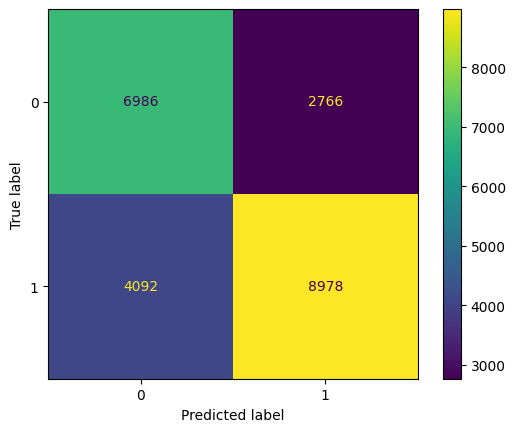

auc score: 0.77


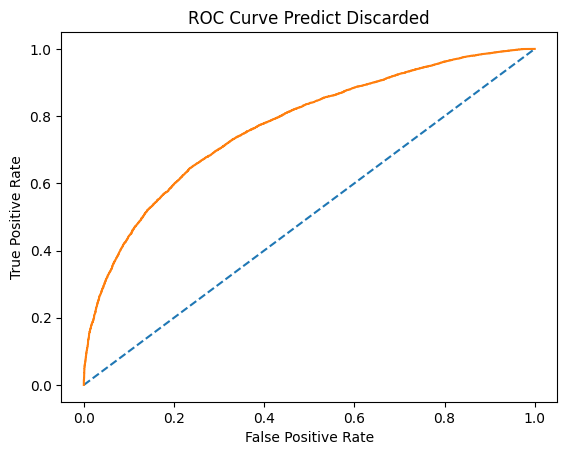

In [63]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model3 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  n_jobs=-1)

# Train the model
model3.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model3.predict(X_test_2)
y_pred_prob = model3.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model3.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

#### Tune model

In [48]:
from tune_sklearn import TuneSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score,roc_auc_score

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.75, random_state= 66)
for kept_index,truncate_index in sss.split(X=X_train_over,y=y_train_over):
    train_kept_index = kept_index
    train_truncate_index = truncate_index
    kept_X, kept_y = X_train_over[X_train_over.index.isin(kept_index)], y_train_over[y_train_over.index.isin(kept_index)]
    truncate_X, truncate_y = X_train_over[X_train_over.index.isin(truncate_index)], y_train_over[y_train_over.index.isin(truncate_index)]

In [53]:
xgb3_tune = xgb.XGBClassifier(objective= "binary:logistic",nthread = -1, device = 'cuda',eval_metric='auc')
param1 = {'max_depth': [9,18,27],
              'learning_rate': [0.05, 0.15, 0.3, 0.02],
              'subsample': np.arange(0.7, 1.0, 0.1).tolist(),
              'colsample_bytree': np.arange(0.7, 1.0, 0.1).tolist(),
              'n_estimators': [50,100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=xgb3_tune, 
                           param_distributions=param1, 
                           n_iter=30,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(X_train_over, y_train_over)
#print(random_search.best_params_)
#print(random_search.cv_results_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           nthread=-1, num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999,
                                                             0.9999999999999999],
                                        'learning_rate': [0.05, 0.15, 0.3,
                                                          0.02],
                                        'max_depth': [9, 18, 27],
                                        'n_estimators': [50, 100, 150, 300],
                                        'subsample': [0.7, 0.7999999999999999,
                                                      0.8999999999999999,
                                                      0.9999999999999999]},
                   refit='f1', scoring='f1', verbose=1)

In [55]:
print(random_search.best_params_)
print(random_search.cv_results_)
print(random_search.best_score_)

{'subsample': 0.8999999999999999, 'n_estimators': 300, 'max_depth': 27, 'learning_rate': 0.02, 'colsample_bytree': 0.7}
{'mean_fit_time': array([ 50.6831193 , 102.48039551,  73.00080075,   6.54640012,
        37.64601064,  17.87560353,   4.07300153,  17.09959874,
        10.12360082,  16.16479893,  41.96019673,  44.50779872,
        45.54360218,  10.22459903,  97.8090569 , 105.90463104,
        10.40039725,  21.65339913,  16.748702  ,  10.43971238,
         4.55859814,  56.32419715,  38.87059512,  89.08179851,
       299.09156704,  19.4599999 , 712.62570491,  45.6961978 ,
       165.64475489,  62.76855574]), 'std_fit_time': array([4.05251017e+00, 1.11154521e+01, 5.84625345e+00, 9.15505346e-02,
       3.72346667e+00, 2.09953376e+00, 3.71830184e-01, 1.33791057e+00,
       6.24973730e-01, 7.33584995e-01, 1.08922269e+00, 8.64056712e-01,
       1.82275354e+00, 2.67033643e-01, 3.63934255e+01, 5.42671392e+01,
       7.03370372e-01, 8.25711970e-01, 1.62313787e+00, 7.64412199e-01,
       5.6544

Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

       False       0.66      0.68      0.67      9752
        True       0.75      0.74      0.75     13070

    accuracy                           0.71     22822
   macro avg       0.71      0.71      0.71     22822
weighted avg       0.71      0.71      0.71     22822



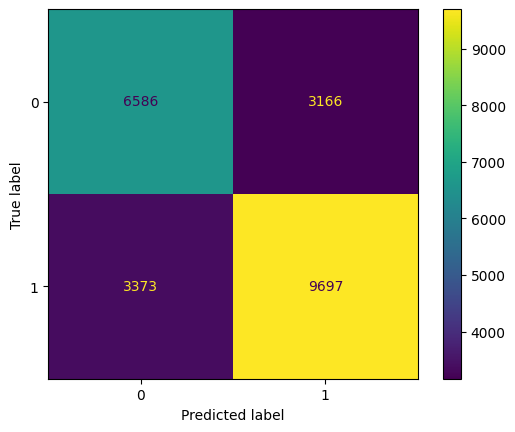

auc score: 0.79


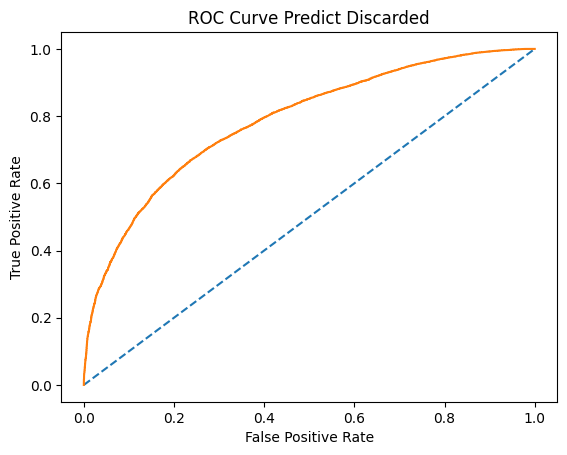

In [59]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model3 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  nthread = -1, device = 'cuda', 
                           subsample=0.9, n_estimators= 300, max_depth= 27, 
                           learning_rate= 0.02, colsample_bytree= 0.7)

# Train the model
model3.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model3.predict(X_test_2)
y_pred_prob = model3.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model3.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

<Axes: >

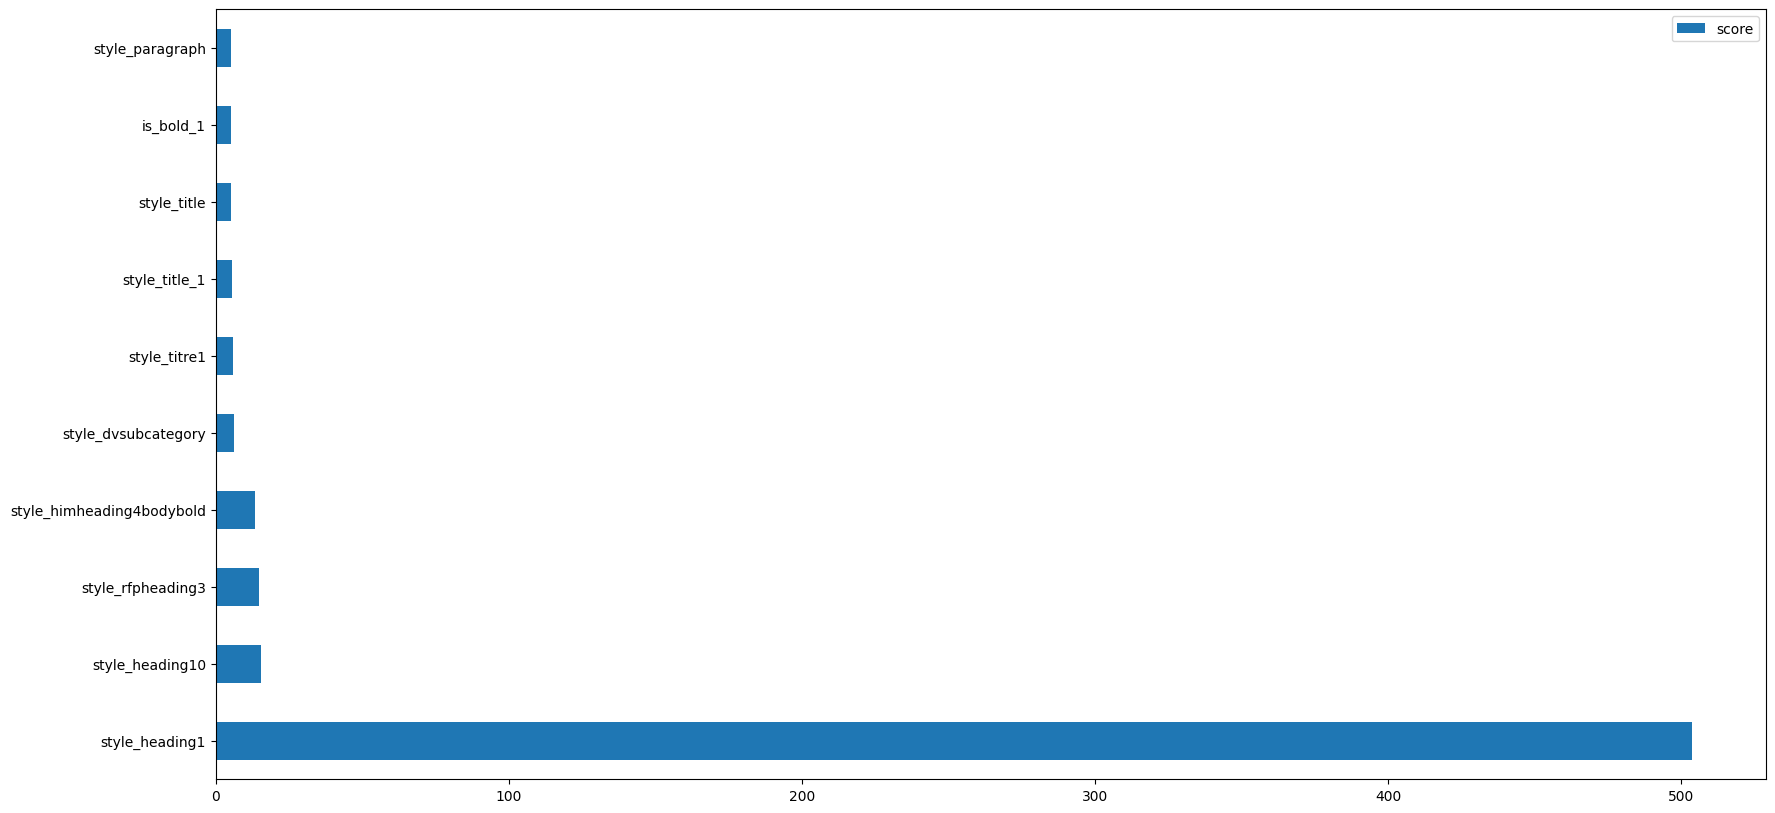

In [60]:
## Important features
feature_important = model3.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

#### Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf3 = RandomForestClassifier(njob = -1,oob_score = 'auc')
param1 = {'criterion': ['gini', 'entropy', 'log_loss'],
              'bootstrap': [True, False],
              'max_depth': np.arange(20, 110, 20).tolist().append(None),
              'min_samples_split':[1,2,4],
              'min_samples_leaf':[2,5,10],
              'n_estimators': [100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=clf3, 
                           param_distributions=param1, 
                           n_iter=20,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(X_train_over, y_train_over)
#print(random_search.best_params_)
#print(random_search.cv_results_)

In [ ]:
print(random_search.best_params_)
print(random_search.cv_results_)

### sub model 4.1 subsection from others

In [61]:
##FOR section
#'target_question',target_discarded','target_subsection','target_section'
train_df_2 = train_df.loc[(train_df['target_discarded'] == 0) & (train_df['target_question'] == 0)]
test_df_2 = test_df.loc[(test_df['target_discarded'] == 0) & (test_df['target_question'] == 0)]
X_train_2 = train_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_train_2 = train_df_2['target_subsection']
X_test_2 = test_df_2.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
y_test_2 = test_df_2['target_subsection']


In [62]:
train_df_2.groupby('target_subsection').count()

,css_pk,customer_pk,html_pk,id,form_rel_depth,form_rel_font_size,lang_num_sents,lang_num_words,lang_mean_words_per_sent,lang_pct_coordinating_conjunction,...,style_q_1,style_ans_1,style_title_1,style_indent_1,style_cover_nm_add_1,style_head_foot_1,target_discarded,target_question,target_section,target
target_subsection,,,,,,,,,,,,,,,,,,,,,
False,46564,46564,46564,46564,46564,46564,46564,46564,46564,46564,...,46564,46564,46564,46564,46564,46564,46564,46564,46564,46564
True,35624,35624,35624,35624,35624,35624,35624,35624,35624,35624,...,35624,35624,35624,35624,35624,35624,35624,35624,35624,35624


In [63]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

Accuracy: 0.70
Classification report:
              precision    recall  f1-score   support

       False       0.77      0.68      0.72     13070
        True       0.63      0.72      0.67      9752

    accuracy                           0.70     22822
   macro avg       0.70      0.70      0.70     22822
weighted avg       0.71      0.70      0.70     22822



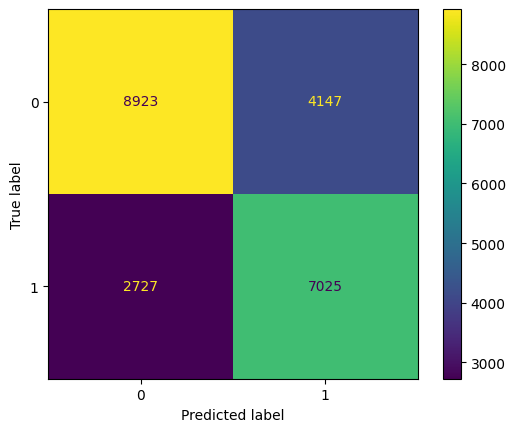

auc score: 0.77


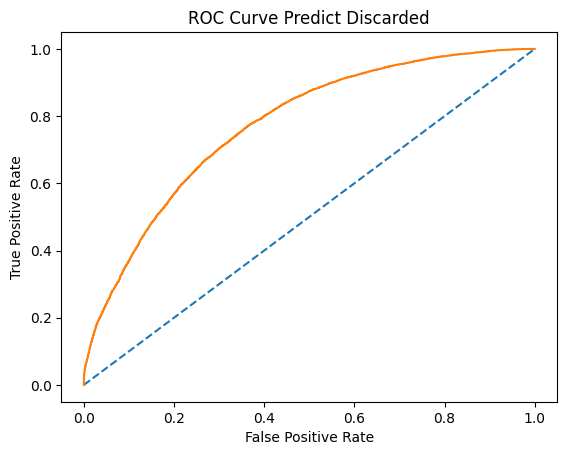

In [64]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model4 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  n_jobs=-1)

# Train the model
model4.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model4.predict(X_test_2)
y_pred_prob = model4.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model4.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

#### Tune model

In [65]:
from tune_sklearn import TuneSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score,roc_auc_score

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.75, random_state= 66)
for kept_index,truncate_index in sss.split(X=X_train_over,y=y_train_over):
    train_kept_index = kept_index
    train_truncate_index = truncate_index
    kept_X, kept_y = X_train_over[X_train_over.index.isin(kept_index)], y_train_over[y_train_over.index.isin(kept_index)]
    truncate_X, truncate_y = X_train_over[X_train_over.index.isin(truncate_index)], y_train_over[y_train_over.index.isin(truncate_index)]

In [66]:
xgb4_tune = xgb.XGBClassifier(objective= "binary:logistic",nthread = -1, device = 'cuda',eval_metric='auc')
param1 = {'max_depth': [6,9,18],
              'learning_rate': [0.05, 0.15, 0.3],
              'subsample': np.arange(0.5, 1.0, 0.1).tolist(),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1).tolist(),
              'n_estimators': [50,100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=xgb4_tune, 
                           param_distributions=param1, 
                           n_iter=30,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(X_train_over, y_train_over)
#print(random_search.best_params_)
#print(random_search.cv_results_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           n_estimators=None, n_jobs=None,
                                           nthread=-1, num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999],
                                        'learning_rate': [0.05, 0.15, 0.3],
                                        'max_depth': [6, 9, 18],
                                        'n_estimators': [50, 100, 150, 300],
                                        'subsample': [0.5, 0.6, 0.7,
                                                      0.7999999999999999,
                                                      0.8999999999999999]},
                   refit='f1', scoring='f1', verbose=1)

In [69]:
print(random_search.best_params_)
print(random_search.cv_results_)
print(random_search.best_score_)

{'subsample': 0.7, 'n_estimators': 300, 'max_depth': 18, 'learning_rate': 0.05, 'colsample_bytree': 0.7999999999999999}
{'mean_fit_time': array([22.73780217,  6.6093987 ,  3.67820063,  2.98299942,  2.80539894,
       19.1595983 ,  6.21939836,  3.06799998, 36.73840756,  5.35299897,
       10.11799927, 18.9530005 ,  3.5972023 ,  1.53979974,  1.57277761,
       22.87640138,  3.79060049,  9.87339997, 19.96599989, 48.30299802,
       22.19759898,  5.53700013,  2.75099926,  3.23499894, 21.03917198,
        8.91080103, 20.97399945, 47.01279821, 21.81999869, 35.11799974]), 'std_fit_time': array([3.38242667, 0.14771316, 0.39963576, 0.10984373, 0.26799695,
       1.9802945 , 0.35267677, 0.38279594, 3.97736199, 0.21630663,
       0.15379233, 2.10231841, 0.17325277, 0.15621985, 0.03304464,
       2.4787692 , 0.19327254, 0.54413256, 0.87016182, 0.93093741,
       0.74479009, 1.12630358, 0.16061254, 0.26215487, 1.45435359,
       0.39980756, 0.25103673, 0.43207614, 0.40762916, 8.10600875]), 'mean_sc

Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

       False       0.76      0.73      0.74     13070
        True       0.66      0.69      0.67      9752

    accuracy                           0.71     22822
   macro avg       0.71      0.71      0.71     22822
weighted avg       0.71      0.71      0.71     22822



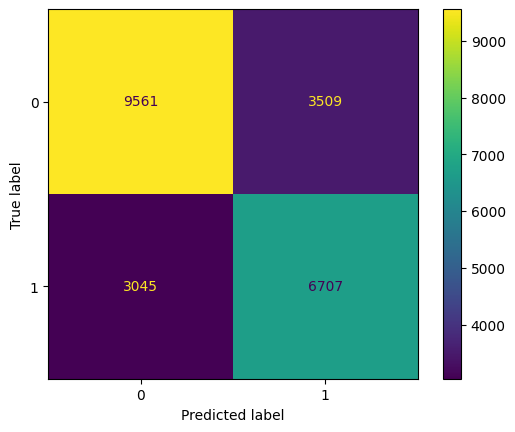

auc score: 0.79


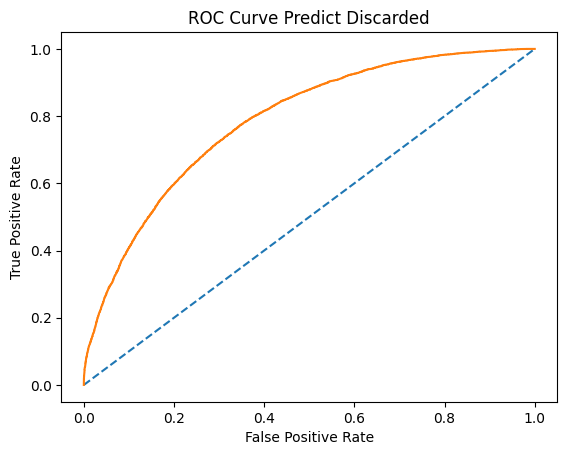

In [70]:
#XGBOOST:
# train one that not tuned
# Initialize the XGBoost model
model4 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  nthread = -1, device = 'cuda', 
                           subsample=0.7, n_estimators= 300, max_depth= 18, 
                           learning_rate= 0.05, colsample_bytree= 0.8)

# Train the model
model4.fit(X_train_over, y_train_over)

# Make predictions
y_pred = model4.predict(X_test_2)
y_pred_prob = model4.predict_proba(X_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification report:") 
print(classification_report(y_test_2,y_pred))#,output_dict=True)) 
cm = confusion_matrix(y_test_2, y_pred, labels=model4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model4.classes_)
disp.plot()
plt.show()

precision, recall, f1_res, _ = precision_recall_fscore_support(y_test_2,y_pred,average='weighted')

######## ROC curve ############
auc = roc_auc_score(y_test_2, y_pred_prob[:,1])
print(f'auc score: {auc:.2f}')
fpr, tpr, thresholds = roc_curve(y_test_2,y_pred_prob[:,1])

plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.show()

<Axes: >

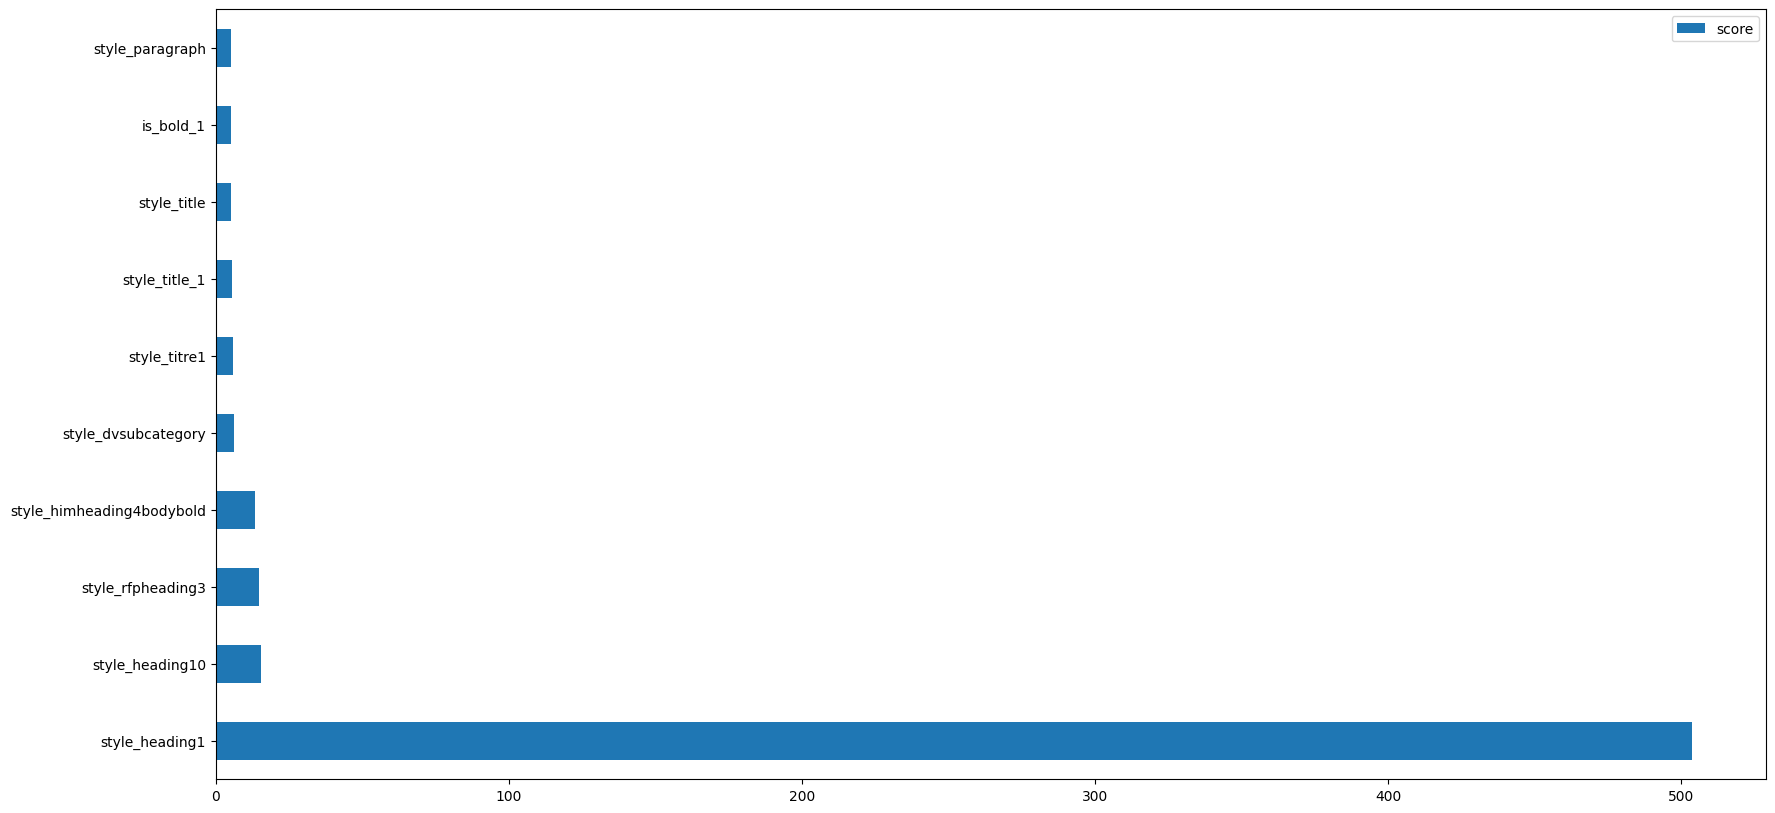

In [71]:
## Important features
feature_important = model2.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

#### Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf4 = RandomForestClassifier(njob = -1,oob_score = 'auc')
param1 = {'criterion': ['gini', 'entropy', 'log_loss'],
              'bootstrap': [True, False],
              'max_depth': np.arange(20, 110, 20).tolist().append(None),
              'min_samples_split':[1,2,4],
              'min_samples_leaf':[2,5,10],
              'n_estimators': [100,150,300]}
#TuneSearchCV(xgb1, param_distributions = param1, n_trials = 10, early_stopping=True, use_gpu=True, scoring = 'f1')
random_search = RandomizedSearchCV(estimator=clf4, 
                           param_distributions=param1, 
                           n_iter=20,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=4, 
                           cv=5, 
                           verbose=1)

random_search.fit(X_train_over, y_train_over)
#print(random_search.best_params_)
#print(random_search.cv_results_)

### CV on the squence model:

In [23]:
r_state = [1,2,3,4,5]
train_df_dict = dict()
test_df_dict = dict()
for r in r_state:
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=10*r)
    train_list = []
    test_list = []

    for i in filtered_df['customer_pk'].unique():
        X = filtered_df.loc[filtered_df['customer_pk'] == i]
        train_index, test_index = next(gss.split(X, groups=X['css_pk']))
        
        train_list.append(X.iloc[train_index])
        test_list.append(X.iloc[test_index])

    train_df_dict[r] = pd.concat(train_list, ignore_index=False)
    test_df_dict[r] = pd.concat(test_list, ignore_index=False)

In [24]:
def train_test_column_drop(train,test,predict_col=str):
    targs = ['target', 'target_question','target_discarded','target_subsection','target_section']
    targs = targs
    X_train = train_df.drop(columns=columns_to_exclude + targs)
    y_train = train_df[predict_col]
    X_test = test_df.drop(columns=columns_to_exclude + targs)
    y_test = test_df[predict_col]

    return X_train,y_train,X_test,y_test

In [48]:
f1_list = list()
f1_list_avg = list()
auc_list = list()
classification_report_list = list()

In [66]:
for lp in range(0,5):
    train_df = train_df_dict[lp+1]
    test_df = test_df_dict[lp+1]
###############FOR DISCARDED

    X_train,y_train,X_test,y_test = train_test_column_drop(train_df,test_df,predict_col='target_discarded')

    model1_cv1 = xgb.XGBClassifier(objective= "binary:logistic",n_job = -1,  tree_method='hist',eval_metric='auc',device='cuda'
                        ,max_depth=9,
            learning_rate=0.15,
            subsample=0.9,
            colsample_bytree=0.6,
            n_estimators=150)#(objective= "binary:logistic",n_job = -1,  tree_method='hist',eval_metric='auc',device='cuda'
                          #,max_depth=27,
              #learning_rate=0.15,#0.15
              #subsample=0.9,
              #colsample_bytree=0.6,#0.6
              #n_estimators=300)

    # Train the model
    model1_cv1.fit(X_train, y_train)

    #######################FOR question

    train_df_2 = train_df.loc[train_df['target_discarded'] != 1]
    test_df_2 = test_df.loc[test_df['target_discarded'] != 1]
    X_train_2,y_train_2,X_test_2,y_test_2 = train_test_column_drop(train_df_2,test_df_2,predict_col='target_question')

    ## oversample the minor class for training, use the original test set for testing
    oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
    X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

    model2_cv1 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  nthread = -1, device = 'cuda', 
                           subsample=0.9, n_estimators= 300, max_depth= 18, 
                           learning_rate= 0.15, colsample_bytree= 0.6)

    # Train the model
    model2_cv1.fit(X_train_over, y_train_over)

    ######################FOR section
    train_df_2 = train_df.loc[(train_df['target_discarded'] == 0) & (train_df['target_question'] == 0)]
    test_df_2 = test_df.loc[(test_df['target_discarded'] == 0) & (test_df['target_question'] == 0)]
    X_train_2,y_train_2,X_test_2,y_test_2 = train_test_column_drop(train_df_2,test_df_2,predict_col='target_section')
    ## oversample the minor class for training, use the original test set for testing
    oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
    X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

    model3_cv1 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  nthread = -1, device = 'cuda', 
                           subsample=0.9, n_estimators= 300, max_depth= 27, 
                           learning_rate= 0.02, colsample_bytree= 0.7)

    # Train the model
    model3_cv1.fit(X_train_over, y_train_over)

    ######################FOR subsection
    #'target_question',target_discarded','target_subsection','target_section'
    train_df_2 = train_df.loc[(train_df['target_discarded'] == 0) & (train_df['target_question'] == 0)]
    test_df_2 = test_df.loc[(test_df['target_discarded'] == 0) & (test_df['target_question'] == 0)]
    X_train_2,y_train_2,X_test_2,y_test_2 = train_test_column_drop(train_df_2,test_df_2,predict_col='target_subsection')
    ## oversample the minor class for training, use the original test set for testing
    oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
    X_train_over, y_train_over = oversample.fit_resample(X_train_2, y_train_2)

    model4_cv1 = xgb.XGBClassifier(eval_metric='auc', objective= "binary:logistic",  nthread = -1, device = 'cuda', 
                            subsample=0.7, n_estimators= 300, max_depth= 18, 
                            learning_rate= 0.05, colsample_bytree= 0.8)

    # Train the model
    model4_cv1.fit(X_train_over, y_train_over)

    ### CV PREDICTION
    X_test = test_df.drop(columns=columns_to_exclude +['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
    y_test = test_df['target_discarded']
    y1_pred = model1_cv1.predict(X_test)
    y1_pred_proba = model1_cv1.predict_proba(X_test)
    not_discard_indices = np.where(y1_pred == 0)[0]
    X_next_stage1 = test_df.iloc[not_discard_indices]
    y_next_stage1 = test_df.iloc[not_discard_indices]['target']
    
    X_test = X_next_stage1.drop(columns=columns_to_exclude + ['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
    y_test = X_next_stage1['target_question']
    y2_pred = model2_cv1.predict(X_test)
    y2_pred_proba = model2_cv1.predict_proba(X_test)
    not_discard_indices2 = np.where(y2_pred == 0)[0]
    X_next_stage2 = test_df.iloc[not_discard_indices2]
    y_next_stage2 = test_df.iloc[not_discard_indices2]['target']

    X_test = X_next_stage2.drop(columns=columns_to_exclude + ['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
    y_test = X_next_stage2['target_section']
    y3_pred = model3_cv1.predict(X_test)
    y3_pred_proba = model3_cv1.predict_proba(X_test)
    not_discard_indices3 = np.where(y3_pred == 0)[0]
    X_next_stage3 = test_df.iloc[not_discard_indices3]
    y_next_stage3 = test_df.iloc[not_discard_indices3]['target']

    X_test = X_next_stage3.drop(columns=columns_to_exclude + ['target']+ ['target_question']
                             + ['target_discarded']+ ['target_subsection']+ ['target_section'])
    y_test = X_next_stage3['target_subsection']
    y4_pred = model4_cv1.predict(X_test)
    y4_pred_proba = model4_cv1.predict_proba(X_test)
    not_discard_indices4 = np.where(y4_pred == 0)[0]
    X_next_stage4 = test_df.iloc[not_discard_indices4]
    y_next_stage4 = test_df.iloc[not_discard_indices4]['target']

    y1 = pd.DataFrame()
    y1['true'] = test_df['target']
    y1.reset_index(inplace=True, drop=True)
    y1['predict'] = pd.DataFrame(y1_pred).astype(int)
    #y1['predict_proba'] = pd.DataFrame(y1_pred_proba)
    y1 = y1.loc[y1.predict == 1]
    #y1.loc[y1['true'] == 'discarded','true'] = 0
    y1.loc[y1['predict'] == 1,'predict'] = 0
    y1 = y1.loc[y1.predict == 0]

    y2 = pd.DataFrame()
    y2['true'] = X_next_stage1['target']
    y2.reset_index(inplace=True, drop=True)
    y2['predict'] = pd.DataFrame(y2_pred).astype(int)
    #y2['predict_proba'] = pd.DataFrame(y2_pred_proba)
    #y2.loc[y2['true'] == 1,'true'] = 1
    y2.loc[y2['predict'] == 1,'predict'] = 1
    y2 = y2.loc[y2.predict == 1]

    y3 = pd.DataFrame()
    y3['true'] = X_next_stage2['target']
    y3.reset_index(inplace=True, drop=True)
    y3['predict'] = pd.DataFrame(y3_pred).astype(int)
    #y3['predict_proba'] = pd.DataFrame(y3_pred_proba)
    #y3.loc[y3['true'] == 1,'true'] = 2
    y3.loc[y3['predict'] == 1,'predict'] = 2
    y3 = y3.loc[y3.predict == 2]

    y4 = pd.DataFrame()
    y4['true'] = X_next_stage3['target']
    y4.reset_index(inplace=True, drop=True)
    y4['predict'] = pd.DataFrame(y4_pred).astype(int)
    #y4['predict_proba'] = pd.DataFrame(y4_pred_proba)
    #y4.loc[y4['true'] == 1,'true'] = 3
    y4.loc[y4['predict'] == 1,'predict'] = 3
    #y4.loc[y4['true'] == 0,'true'] = 4
    y4.loc[y4['predict'] == 0,'predict'] = 4
    #y4 = y4.loc[y4.predict == 3]

    y_final = pd.concat([y1,y2,y3,y4])
    y_final.loc[y_final['true'] == 'discarded','true'] = 0 
    y_final.loc[y_final['true'] == 'question','true'] = 1 
    y_final.loc[y_final['true'] == 'section','true'] = 2 
    y_final.loc[y_final['true'] == 'subsection','true'] = 3 
    y_final.true = y_final.true.astype(int)

    print(lp)
    print(f1_score(y_final.true, y_final.predict, average='macro'))
    print(f1_score(y_final.true, y_final.predict, average='micro'))
    print(f1_score(y_final.true, y_final.predict, average='weighted'))

    f1_list_avg.append(f1_score(y_final.true, y_final.predict, average='weighted'))
    print(f1_score(y_final.true, y_final.predict, average=None))

    f1_list.append(f1_score(y_final.true, y_final.predict, average=None))
    print(y_final.shape)
    print(test_df.shape)
    #print(y_final.predict.unique)

    classification_report_list.append(classification_report(y_final.true,y_final.predict,target_names = ['discarded','question','section','subsection','unknown']))

c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [20:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_job" } are not used.

  warnings.warn(smsg, UserWarning)


0
0.36448231817106586
0.7724263943870253
0.7882421608425942
[0.81189582 0.79663393 0.1215971  0.09228474 0.        ]
(680281, 2)
(680281, 122)


c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

1
0.36759684273314597
0.7826808213243651
0.7982041757097593
[0.82192741 0.80726028 0.11688819 0.09190833 0.        ]
(662491, 2)
(662491, 122)


c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

2
0.3605404284874193
0.7740286923555133
0.7887717193336402
[0.81077584 0.79955174 0.1052525  0.08712206 0.        ]
(670771, 2)
(670771, 122)


c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

3
0.3643014877808743
0.780468856561679
0.7959003352955557
[0.82252104 0.80151449 0.11446452 0.08300739 0.        ]
(674492, 2)
(674492, 122)


c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

4
0.365531414068997
0.784423898943227
0.7995264865315137
[0.82435698 0.80791311 0.10489442 0.09049255 0.        ]
(679143, 2)
(679143, 122)


c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [71]:
print(f1_list_avg)

[0.7882421608425942, 0.7982041757097593, 0.7887717193336402, 0.7959003352955557, 0.7995264865315137]


In [72]:
print(f1_list)

[array([0.81189582, 0.79663393, 0.1215971 , 0.09228474, 0.        ]), array([0.82192741, 0.80726028, 0.11688819, 0.09190833, 0.        ]), array([0.81077584, 0.79955174, 0.1052525 , 0.08712206, 0.        ]), array([0.82252104, 0.80151449, 0.11446452, 0.08300739, 0.        ]), array([0.82435698, 0.80791311, 0.10489442, 0.09049255, 0.        ])]


In [67]:
print(classification_report_list[0])


              precision    recall  f1-score   support

   discarded       0.80      0.82      0.81    341941
    question       0.84      0.75      0.80    322472
     section       0.43      0.07      0.12      8501
  subsection       0.21      0.06      0.09      7367
     unknown       0.00      0.00      0.00         0

    accuracy                           0.77    680281
   macro avg       0.46      0.34      0.36    680281
weighted avg       0.81      0.77      0.79    680281



In [68]:
print(classification_report_list[1])

              precision    recall  f1-score   support

   discarded       0.80      0.84      0.82    327524
    question       0.86      0.76      0.81    319557
     section       0.42      0.07      0.12      8813
  subsection       0.20      0.06      0.09      6597
     unknown       0.00      0.00      0.00         0

    accuracy                           0.78    662491
   macro avg       0.46      0.35      0.37    662491
weighted avg       0.82      0.78      0.80    662491



In [69]:
print(classification_report_list[2])

              precision    recall  f1-score   support

   discarded       0.80      0.83      0.81    330746
    question       0.85      0.76      0.80    324447
     section       0.39      0.06      0.11      8548
  subsection       0.20      0.06      0.09      7030
     unknown       0.00      0.00      0.00         0

    accuracy                           0.77    670771
   macro avg       0.45      0.34      0.36    670771
weighted avg       0.81      0.77      0.79    670771



In [70]:
print(classification_report_list[3])

              precision    recall  f1-score   support

   discarded       0.81      0.84      0.82    342308
    question       0.86      0.75      0.80    316535
     section       0.40      0.07      0.11      8472
  subsection       0.19      0.05      0.08      7177
     unknown       0.00      0.00      0.00         0

    accuracy                           0.78    674492
   macro avg       0.45      0.34      0.36    674492
weighted avg       0.82      0.78      0.80    674492



In [39]:
print(test_df['target_discarded'].shape)
print(np.shape(np.where(y1_pred == 1)[0]), y1.shape)
print(np.shape(np.where(y1_pred == 0)[0]))
print(np.shape(np.where(y2_pred == 1)[0]),y2.shape)
print(np.shape(np.where(y2_pred == 0)[0]))
print(np.shape(np.where(y3_pred == 1)[0]),y3.shape)
print(np.shape(np.where(y3_pred == 0)[0]))
print(np.shape(np.where(y4_pred == 1)[0]),y4.shape)
print(np.shape(np.where(y4_pred == 0)[0]))

(680281,)
(350840,) (350840, 2)
(329441,)
(288325,) (288325, 2)
(41116,)
(1408,) (1408, 2)
(39708,)
(2058,) (39708, 2)
(37650,)
